# Deep Learning 2024 - project 2
Kinga Frańczak, 313335

Grzegorz Zakrzewski, 313555

In [1]:
# tensorflow==2.10.1
# pandas==1.5.3
# numpy==1.26.4
# seaborn==0.13.2
# matplotlib==3.8.3
# scipy==1.13

import collections
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.io import wavfile
from tensorflow import keras

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=0.9)
np.random.seed(0)
keras.utils.set_random_seed(0)

#### Creating *silence* from *_background_noise_*

In [2]:
# BACKGROUND_NOISE_PATH = "tensorflow-speech-recognition-challenge/train/audio/_background_noise_/"
# SILENCE_PATH = "tensorflow-speech-recognition-challenge/train/audio/silence/"
# os.makedirs(SILENCE_PATH, exist_ok=True)

# for file in os.listdir(BACKGROUND_NOISE_PATH):
#     if not file.endswith("wav"):
#         continue

#     _, samples = wavfile.read(BACKGROUND_NOISE_PATH + file)

#     samples = samples[:samples.shape[0] - samples.shape[0] % 200]
#     for idx, i in enumerate(range(0, samples.shape[0], 200)):
        
#         new_file = SILENCE_PATH + file.split(".")[0] + f"_{idx}.wav"
#         wavfile.write(new_file, 16000, samples[i: i + 16000])

# shutil.rmtree(BACKGROUND_NOISE_PATH)

#### Loading data

In [3]:
REPETITIONS = 5  # number of repetitions of each experiment
EPOCHS = 20  # number of epochs usually used to train the models

CLASSES = [
    "yes", # 
    "no", # 
    "up", #
    "down", # 
    "left", #
    "right", #
    "on", #
    "off", #
    "stop", #
    "go", #
    "silence", #
    "bed",
    "bird",
    "cat",
    "dog",
    "eight",
    "five",
    "four",
    "happy",
    "house",
    "marvin",
    "nine",
    "one",
    "seven", 
    "sheila",
    "six",
    "three",
    "tree",
    "two",
    "wow",
    "zero",
]

directory_train = "./tensorflow-speech-recognition-challenge/train/audio"
directory_test = "./tensorflow-speech-recognition-challenge/test/audio"

In [4]:
DS_TRAIN, DS_VALID = keras.utils.audio_dataset_from_directory(
    directory_train,
    labels="inferred",
    class_names=CLASSES,
    output_sequence_length=16000,
    batch_size=None,
    validation_split=0.2,
    subset="both",
    seed=0,
)

# dropping the extra axis, because this dataset only contains single channel audio
# as in https://www.tensorflow.org/tutorials/audio/simple_audio
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

DS_TRAIN = DS_TRAIN.map(squeeze, tf.data.AUTOTUNE)
DS_VALID = DS_VALID.map(squeeze, tf.data.AUTOTUNE)

Found 96671 files belonging to 31 classes.
Using 77337 files for training.
Using 19334 files for validation.


In [5]:
# DS_TEST = keras.utils.audio_dataset_from_directory(
#     directory_test,
#     labels=None,
#     output_sequence_length=16000,
#     batch_size=None,
#     seed=0,
#     shuffle=False
# )

# DS_TEST = DS_TEST.map(lambda audio: tf.squeeze(audio, axis=-1), tf.data.AUTOTUNE)

In [6]:
for example_audio, example_label in DS_TRAIN.take(1):  
    print(example_audio.shape)
    print(example_label.shape)

(16000,)
()


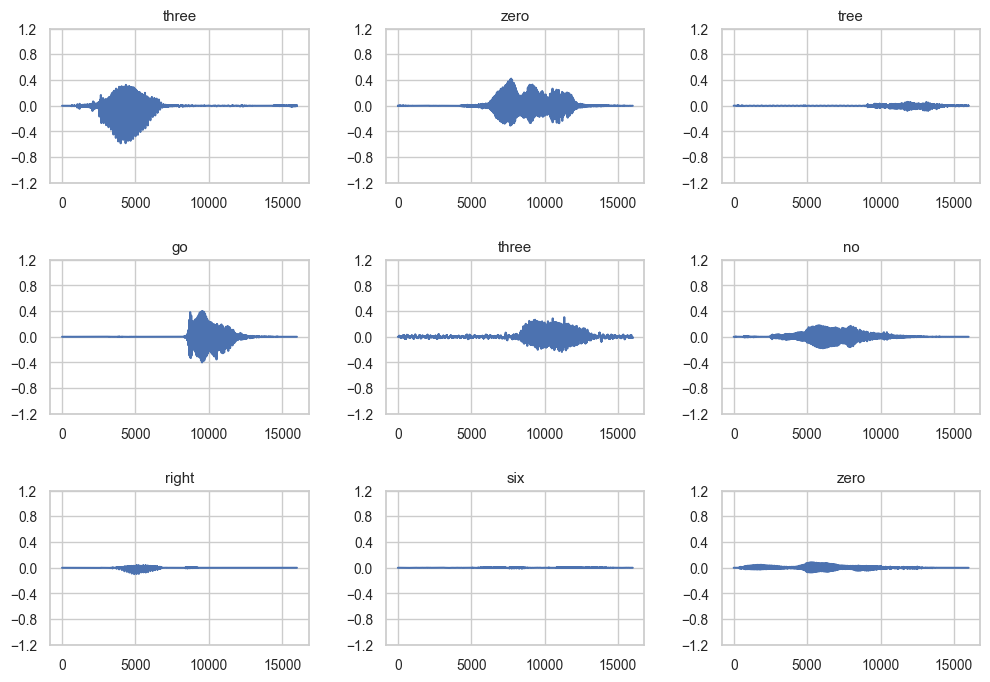

In [7]:
# modified code from https://www.tensorflow.org/tutorials/audio/simple_audio#import_the_mini_speech_commands_dataset
# sample observations
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

for i, (example_audio, example_label) in enumerate(DS_TRAIN.take(9)):
    ax_idx = (i // 3, i % 3)
    axs[ax_idx].plot(example_audio)
    axs[ax_idx].set_title(CLASSES[example_label])
    axs[ax_idx].set_yticks(np.arange(-1.2, 1.21, 0.4))
    axs[ax_idx].set_ylim([-1.2, 1.2])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.savefig(f"images/sample_observations.png", bbox_inches="tight", dpi=300)
plt.show()

In [8]:
# re-labeling everything to the unknown class except the 10 base classes and the silence class
def relabel_map(audio, label):
    label = tf.where(label > 11, 11, label)
    return audio, label

DS_TRAIN = DS_TRAIN.map(relabel_map)
DS_VALID = DS_VALID.map(relabel_map)

#### Converting waveforms to spectrograms

In [9]:
# modified code from https://www.tensorflow.org/tutorials/audio/simple_audio#convert_waveforms_to_spectrograms
# frame_length and frame_step were chosen arbitrarily

def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=240, frame_step=120)
  spectrogram = tf.abs(spectrogram)
  # spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

DS_TRAIN = DS_TRAIN.map(lambda audio, labels: (get_spectrogram(audio), labels), tf.data.AUTOTUNE)
DS_VALID = DS_VALID.map(lambda audio, labels: (get_spectrogram(audio), labels), tf.data.AUTOTUNE)
# DS_TEST = DS_TEST.map(lambda audio: get_spectrogram(audio, tf.data.AUTOTUNE)

In [10]:
# we end up with 132 x 129 vector
DS_TRAIN.element_spec

(TensorSpec(shape=(132, 129), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

#### Counting labels

In [11]:
# counting labels
counts = collections.defaultdict(int)
for audio, label in DS_TRAIN:
    counts[label.numpy()] += 1
counts

defaultdict(int,
            {10: 25670,
             4: 1886,
             5: 1907,
             11: 32764,
             7: 1869,
             1: 1898,
             3: 1879,
             2: 1895,
             0: 1870,
             6: 1899,
             8: 1899,
             9: 1901})

In [12]:
# there are significantly more observations of the 'unknown' and 'silence' classes

# for setup I - one network for all classes
# we will randomly drop 90% of observations from the 'unknown' and 'silence' classes
# this is to prevent issues related to class imbalance.

def randomly_drop_11th_class(audio, label):
    r = tf.random.uniform(shape=[], minval=0, maxval=1, seed=0)
    return label < 10 or (label == 10 and r < 0.1) or (label == 11 and r < 0.1)

DS_TRAIN_1 = DS_TRAIN.filter(randomly_drop_11th_class)
DS_VALID_1 = DS_VALID.filter(randomly_drop_11th_class)

counts = collections.defaultdict(int)
for audio, label in DS_TRAIN_1:
    counts[label.numpy()] += 1
counts

defaultdict(int,
            {10: 2646,
             1: 1898,
             8: 1899,
             11: 3334,
             4: 1886,
             6: 1899,
             0: 1870,
             2: 1895,
             3: 1879,
             9: 1901,
             5: 1907,
             7: 1869})

In [13]:
# for setup II - utilizing one network for special cases and another for the ten base classes
# there will be two datasets
# the first dataset includes all observations, but classes 0-9 are relabeled as one class
# the second dataset contains observations exclusively from the ten base classes

def relabel_map(audio, label):
    label = tf.where(label < 10, 0, label)
    label = tf.where(label == 10, 1, label)
    label = tf.where(label == 11, 2, label)
    return audio, label

DS_TRAIN_2A = DS_TRAIN.map(relabel_map)
DS_VALID_2A = DS_VALID.map(relabel_map)

DS_TRAIN_2B = DS_TRAIN.filter(lambda audio, label: label < 10)
DS_VALID_2B = DS_VALID.filter(lambda audio, label: label < 10)

In [14]:
counts = collections.defaultdict(int)
for audio, label in DS_TRAIN_2A:
    counts[label.numpy()] += 1
counts

defaultdict(int, {1: 25670, 0: 18903, 2: 32764})

In [15]:
counts = collections.defaultdict(int)
for audio, label in DS_TRAIN_2B:
    counts[label.numpy()] += 1
counts

defaultdict(int,
            {0: 1870,
             8: 1899,
             9: 1901,
             2: 1895,
             6: 1899,
             3: 1879,
             5: 1907,
             1: 1898,
             7: 1869,
             4: 1886})

In [16]:
DS_TRAIN = DS_TRAIN.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID = DS_VALID.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_TRAIN_1 = DS_TRAIN_1.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID_1 = DS_VALID_1.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_TRAIN_2A = DS_TRAIN_2A.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID_2A = DS_VALID_2A.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_TRAIN_2B = DS_TRAIN_2B.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID_2B = DS_VALID_2B.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
# DS_TEST = DS_TEST.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

#### Transformer - encoder

![](images/transformer.png)

In [17]:
# modified code from https://www.tensorflow.org/text/tutorials/transformer#define_the_components

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = SelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,
        )
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x


class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.enc_layers = [
            EncoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x

#### Additional functions

In [18]:
# function that fits the model and returns the results

def fit_model(
    get_model,
    name="",
    callbacks=[],
    optimizer="adam",
    ds_train=DS_TRAIN,
    ds_valid=DS_VALID,
    epochs=EPOCHS,
    repetitions=REPETITIONS,
):
    results = []
    models = []
    for i in range(repetitions):
        model = get_model()
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        history = model.fit(ds_train, validation_data=ds_valid, epochs=epochs, callbacks=callbacks)
        frame = pd.DataFrame(history.history)
        frame["Name"] = name
        frame["Repetition"] = i
        frame = frame.reset_index().rename(columns={"index": "Epoch"})
        results.append(frame)
        models.append(model)
    return pd.concat(results), models

In [19]:
# function that returns the lowest loss and the highest accuracy averaged over repetitions

def summary(results):
    tmp = (
        results.groupby(["Name", "Repetition"])
        .agg({"loss": "min", "accuracy": "max", "val_loss": "min", "val_accuracy": "max"})
        .groupby("Name", sort=False)
    )
    mean = tmp.mean().round(3).applymap(lambda x: f"{x:.3f}")
    std = tmp.std().round(3).applymap(lambda x: f" ({x:.3f})")
    summary = mean + std
    return summary

In [34]:
# function that plots accuracy measure on validation set over epochs

def epoch_plot_accuracy(results, name, filename):
    tmp = (
        results.groupby([ "Name", "Epoch"])
        .agg({"val_accuracy": "mean"})
        .reset_index()
        .rename(columns={"Name": name})
    )
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.lineplot(data=tmp, x="Epoch", y="val_accuracy", hue=name, ax=ax)
    ax.set_ylim(0.0, 1)
    ax.set_xlim(-1, 20)
    ax.set_ylabel("Accuracy (validation set)")
    ax.set_xticks(ticks=[4, 9, 14, 19], labels=[5, 10, 15, 20])
    sns.move_legend(ax, "lower right")
    plt.savefig(f"images/{filename}", bbox_inches="tight", dpi=300)
    plt.show()

### Experiment 1 - network architectures

In [21]:
input_shape = (132, 129)

In [22]:
# Model - simple feed-forward neural network

def get_model_simple():
    model_simple = keras.models.Sequential()
    model_simple.add(keras.Input(shape=input_shape))
    model_simple.add(keras.layers.Resizing(32, 32))
    model_simple.add(keras.layers.BatchNormalization())
    model_simple.add(keras.layers.Dense(32, activation='relu')) 
    model_simple.add(keras.layers.Dropout(0.2))
    model_simple.add(keras.layers.Dense(32, activation='relu')) 
    model_simple.add(keras.layers.Dropout(0.2))
    model_simple.add(keras.layers.Dense(32, activation='relu')) 
    model_simple.add(keras.layers.Dropout(0.2))
    model_simple.add(keras.layers.Flatten())
    model_simple.add(keras.layers.Dense(12, activation='softmax'))
    return model_simple

results_simple, models = fit_model(get_model_simple, name="Feed-forward", ds_train=DS_TRAIN_1, ds_valid=DS_VALID_1)
results_simple.to_csv("results/experiment1_results_simple.csv", index=False)

Epoch 1/20
775/775 [==============================] - 17s 20ms/step - loss: 1.9604 - accuracy: 0.3198 - val_loss: 1.6078 - val_accuracy: 0.4806
Epoch 2/20
775/775 [==============================] - 2s 2ms/step - loss: 1.5760 - accuracy: 0.4702 - val_loss: 1.4315 - val_accuracy: 0.5487
Epoch 3/20
775/775 [==============================] - 2s 2ms/step - loss: 1.4563 - accuracy: 0.5208 - val_loss: 1.3540 - val_accuracy: 0.5787
Epoch 4/20
775/775 [==============================] - 2s 2ms/step - loss: 1.3788 - accuracy: 0.5458 - val_loss: 1.2981 - val_accuracy: 0.5952
Epoch 5/20
775/775 [==============================] - 2s 2ms/step - loss: 1.3347 - accuracy: 0.5657 - val_loss: 1.2680 - val_accuracy: 0.6048
Epoch 6/20
775/775 [==============================] - 2s 2ms/step - loss: 1.3017 - accuracy: 0.5733 - val_loss: 1.2378 - val_accuracy: 0.6125
Epoch 7/20
775/775 [==============================] - 2s 2ms/step - loss: 1.2670 - accuracy: 0.5854 - val_loss: 1.2165 - val_accuracy: 0.6221
Epoc

In [23]:
# Model - convolutional neural network

def get_model_cnn():
    model_cnn = keras.models.Sequential()
    model_cnn.add(keras.Input(shape=(132, 129, 1)))
    model_cnn.add(keras.layers.Resizing(32, 32))
    model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(keras.layers.BatchNormalization())
    model_cnn.add(keras.layers.Flatten())
    model_cnn.add(keras.layers.Dropout(0.2))
    model_cnn.add(keras.layers.Dense(32, activation='relu')) 
    model_cnn.add(keras.layers.Dense(12, activation='softmax'))
    return model_cnn

results_cnn, models = fit_model(get_model_cnn, name="CNN", ds_train=DS_TRAIN_1, ds_valid=DS_VALID_1)
results_cnn.to_csv("results/experiment1_results_cnn.csv", index=False)

Epoch 1/20
775/775 [==============================] - 5s 3ms/step - loss: 1.7783 - accuracy: 0.3875 - val_loss: 1.1898 - val_accuracy: 0.5958
Epoch 2/20
775/775 [==============================] - 2s 2ms/step - loss: 1.0470 - accuracy: 0.6397 - val_loss: 0.8647 - val_accuracy: 0.7063
Epoch 3/20
775/775 [==============================] - 2s 2ms/step - loss: 0.8201 - accuracy: 0.7170 - val_loss: 0.7175 - val_accuracy: 0.7670
Epoch 4/20
775/775 [==============================] - 2s 2ms/step - loss: 0.7152 - accuracy: 0.7582 - val_loss: 0.6557 - val_accuracy: 0.7801
Epoch 5/20
775/775 [==============================] - 2s 2ms/step - loss: 0.6434 - accuracy: 0.7835 - val_loss: 0.6654 - val_accuracy: 0.7819
Epoch 6/20
775/775 [==============================] - 2s 2ms/step - loss: 0.6022 - accuracy: 0.7967 - val_loss: 0.6478 - val_accuracy: 0.7848
Epoch 7/20
775/775 [==============================] - 2s 2ms/step - loss: 0.5591 - accuracy: 0.8116 - val_loss: 0.5264 - val_accuracy: 0.8306
Epoch 

In [24]:
# Model - transformer

def get_model_transformer():
    model_t = keras.models.Sequential()
    model_t.add(keras.Input(shape=input_shape))
    model_t.add(Encoder(num_layers=4, d_model=129, num_heads=2, dff=132))
    model_t.add(keras.layers.BatchNormalization())
    model_t.add(keras.layers.Flatten())
    model_t.add(keras.layers.Dropout(0.2))
    model_t.add(keras.layers.Dense(32, activation='relu')) 
    model_t.add(keras.layers.Dense(12, activation='softmax'))
    return model_t

results_t, models = fit_model(get_model_transformer, name="Transformer", ds_train=DS_TRAIN_1, ds_valid=DS_VALID_1)
results_t.to_csv("results/experiment1_results_transformer.csv", index=False)

Epoch 1/20
775/775 [==============================] - 14s 16ms/step - loss: 1.5042 - accuracy: 0.5068 - val_loss: 1.6242 - val_accuracy: 0.5163
Epoch 2/20
775/775 [==============================] - 12s 16ms/step - loss: 0.8868 - accuracy: 0.7118 - val_loss: 0.8574 - val_accuracy: 0.7252
Epoch 3/20
775/775 [==============================] - 12s 16ms/step - loss: 0.6463 - accuracy: 0.7877 - val_loss: 0.6593 - val_accuracy: 0.7803
Epoch 4/20
775/775 [==============================] - 12s 16ms/step - loss: 0.5512 - accuracy: 0.8188 - val_loss: 0.5551 - val_accuracy: 0.8191
Epoch 5/20
775/775 [==============================] - 12s 16ms/step - loss: 0.5002 - accuracy: 0.8345 - val_loss: 0.5730 - val_accuracy: 0.8119
Epoch 6/20
775/775 [==============================] - 12s 16ms/step - loss: 0.4568 - accuracy: 0.8497 - val_loss: 0.5441 - val_accuracy: 0.8370
Epoch 7/20
775/775 [==============================] - 12s 16ms/step - loss: 0.3964 - accuracy: 0.8687 - val_loss: 0.4776 - val_accuracy:

In [28]:
experiment1_results = pd.concat([
    pd.read_csv("results/experiment1_results_simple.csv"),
    pd.read_csv("results/experiment1_results_cnn.csv"), 
    pd.read_csv("results/experiment1_results_transformer.csv")
])

In [36]:
summary(experiment1_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
CNN,0.368 (0.011),0.876 (0.004),0.451 (0.018),0.857 (0.007)
Feed-forward,1.088 (0.007),0.648 (0.002),1.039 (0.006),0.687 (0.005)
Transformer,0.207 (0.010),0.930 (0.003),0.360 (0.018),0.896 (0.004)


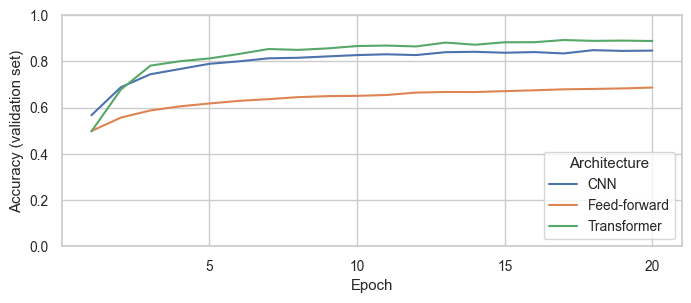

In [37]:
epoch_plot_accuracy(experiment1_results, "Architecture", "experiment1.png")

### Experiment 2 - hyper-parameters

#### Experiment 2.1. - MultiHeadAttention num_heads

In [ ]:
experiment21_results = []

for num_heads in [2, 4, 6, 8, 10]:
    def get_model_transformer():
        model_t = keras.models.Sequential()
        model_t.add(keras.Input(shape=input_shape))
        model_t.add(Encoder(num_layers=4, d_model=129, num_heads=num_heads, dff=132))
        model_t.add(keras.layers.BatchNormalization())
        model_t.add(keras.layers.Flatten())
        model_t.add(keras.layers.Dropout(0.2))
        model_t.add(keras.layers.Dense(32, activation='relu')) 
        model_t.add(keras.layers.Dense(12, activation='softmax'))
        return model_t

    results_t, models = fit_model(get_model_transformer, name=num_heads, ds_train=DS_TRAIN_1, ds_valid=DS_VALID_1)
    experiment21_results.append(results_t)

experiment21_results = pd.concat(experiment21_results)
experiment21_results.to_csv("results/experiment21_results.csv", index=False)

In [59]:
experiment21_results = pd.read_csv("results/experiment21_results.csv").astype({"Name": str})
summary(experiment21_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
10,0.605 (0.072),0.803 (0.023),0.632 (0.048),0.798 (0.012)
2,0.206 (0.010),0.930 (0.004),0.355 (0.017),0.901 (0.003)
4,0.256 (0.024),0.914 (0.008),0.369 (0.032),0.888 (0.012)
6,0.402 (0.107),0.866 (0.036),0.480 (0.059),0.845 (0.025)
8,0.623 (0.061),0.794 (0.021),0.645 (0.039),0.791 (0.016)


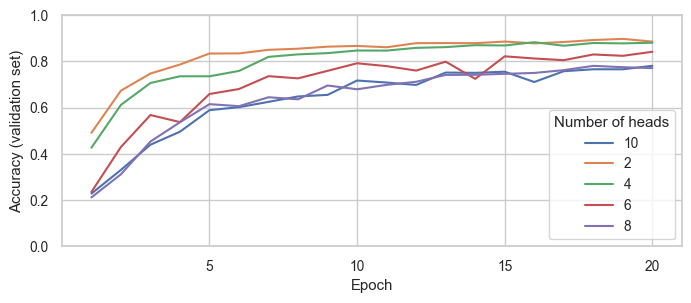

In [60]:
epoch_plot_accuracy(experiment21_results, "Number of heads", "experiment21.png")

#### Experiment 2.2. - number of Encoder layers

In [ ]:
# the best num_heades from Experiment 2.1 is: 
    # 2

experiment22_results = []

for num_layers in [2, 4, 6, 8]:
    def get_model_transformer():
        model_t = keras.models.Sequential()
        model_t.add(keras.Input(shape=input_shape))
        model_t.add(Encoder(num_layers=num_layers, d_model=129, num_heads=2, dff=132))
        model_t.add(keras.layers.BatchNormalization())
        model_t.add(keras.layers.Flatten())
        model_t.add(keras.layers.Dropout(0.2))
        model_t.add(keras.layers.Dense(32, activation='relu')) 
        model_t.add(keras.layers.Dense(12, activation='softmax'))
        return model_t

    results_t, models = fit_model(get_model_transformer, name=num_layers, ds_train=DS_TRAIN_1, ds_valid=DS_VALID_1)
    experiment22_results.append(results_t)

experiment22_results = pd.concat(experiment22_results)
experiment22_results.to_csv("results/experiment22_results.csv", index=False)

In [68]:
experiment22_results = pd.read_csv("results/experiment22_results.csv").astype({"Name": str})
summary(experiment22_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
2,0.170 (0.009),0.941 (0.003),0.484 (0.017),0.875 (0.004)
4,0.206 (0.012),0.930 (0.004),0.380 (0.023),0.897 (0.006)
6,0.284 (0.044),0.905 (0.015),0.390 (0.032),0.884 (0.009)
8,1.503 (0.416),0.468 (0.132),1.685 (0.508),0.424 (0.174)


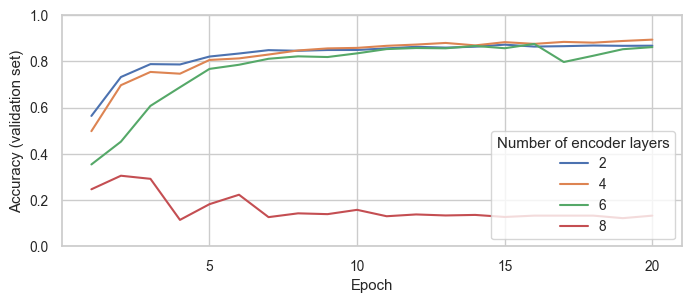

In [70]:
epoch_plot_accuracy(experiment22_results, "Number of encoder layers", "experiment22.png")

### Experiment 3 - "unknown" and "silence" classes

In [ ]:
# the best num_heades from Experiment 2.1 is: 
    # 2

# the best num_layers from Experiment 2.2 is: 
    # 4

In [ ]:
def get_model_transformer_a():
    model_t = keras.models.Sequential()
    model_t.add(keras.Input(shape=input_shape))
    model_t.add(Encoder(num_layers=4, d_model=129, num_heads=2, dff=132))
    model_t.add(keras.layers.BatchNormalization())
    model_t.add(keras.layers.Flatten())
    model_t.add(keras.layers.Dropout(0.2))
    model_t.add(keras.layers.Dense(32, activation='relu')) 
    model_t.add(keras.layers.Dense(3, activation='softmax'))
    return model_t

results_t_a, models_a = fit_model(get_model_transformer_a, name="Transformer A", ds_train=DS_TRAIN_2A, ds_valid=DS_VALID_2A)

In [ ]:
def get_model_transformer_b():
    model_t = keras.models.Sequential()
    model_t.add(keras.Input(shape=input_shape))
    model_t.add(Encoder(num_layers=4, d_model=129, num_heads=2, dff=132))
    model_t.add(keras.layers.BatchNormalization())
    model_t.add(keras.layers.Flatten())
    model_t.add(keras.layers.Dropout(0.2))
    model_t.add(keras.layers.Dense(32, activation='relu')) 
    model_t.add(keras.layers.Dense(10, activation='softmax'))
    return model_t

results_t_b, models_b = fit_model(get_model_transformer_b, name="Transformer B", ds_train=DS_TRAIN_2B, ds_valid=DS_VALID_2B)

In [ ]:
arrs = []
for _, labels in DS_TRAIN:
    arrs.append(labels.numpy())
labels_true = np.concatenate(arrs)

acc_list = []

for model_a, model_b in zip(models_a, models_b):
    labels_pred_proba_a = model_a.predict(DS_TRAIN)
    labels_pred_a = labels_pred_proba_a.argmax(axis=1)
    labels_pred_a[labels_pred_a == 1] = 11
    labels_pred_a[labels_pred_a == 2] = 12

    labels_pred_proba_b = model_b.predict(DS_TRAIN)
    labels_pred_b = labels_pred_proba_b.argmax(axis=1)

    labels_pred = np.where(labels_pred_a == 0, labels_pred_b, labels_pred_a)

    m = keras.metrics.Accuracy()
    m.update_state(labels_true, labels_pred)
    acc = m.result()
    acc_list.append(acc)

acc_list = np.array(acc_list)
print(acc_list.mean(), acc_list.std())

In [ ]:
arrs = []
for _, labels in DS_VALID:
    arrs.append(labels.numpy())
labels_true = np.concatenate(arrs)

acc_list = []

for model_a, model_b in zip(models_a, models_b):
    labels_pred_proba_a = model_a.predict(DS_VALID)
    labels_pred_a = labels_pred_proba_a.argmax(axis=1)
    labels_pred_a[labels_pred_a == 1] = 11
    labels_pred_a[labels_pred_a == 2] = 12

    labels_pred_proba_b = model_b.predict(DS_VALID)
    labels_pred_b = labels_pred_proba_b.argmax(axis=1)

    labels_pred = np.where(labels_pred_a == 0, labels_pred_b, labels_pred_a)

    m = keras.metrics.Accuracy()
    m.update_state(labels_true, labels_pred)
    acc = m.result()
    acc_list.append(acc)

acc_list = np.array(acc_list)
print(acc_list.mean(), acc_list.std())